In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import fontManager, FontProperties
from wordcloud import WordCloud
from datetime import date
import os

## Defining Globals

In [118]:
# Define colors for customization
COLORS = ['#598f91', '#93b071', '#0c3547', '#10656d', '#edae93', '#dd6670', '#ede2cc']
COLORS_L = ['#2c4875', '#8a508f', '#bc5090', '#b82e2e', '#ffd380', '#ff8531', '#ffa600', 
            '#cfbcbc', '#598f91', '#93b071', '#0c3547', '#10656d', '#edae93', '#dd6670', '#ede2cc']
COLORS_12 = ['#5C4B51', '#8CBEB2', '#F2EBBF', '#F3B562', '#DA073B', '#353f15', '#e65406', 
             '#c84c44', '#17b320', '#1D6D21', '#605cdc', '#2C4981', '#192A4D']
COLORS_GR_B = ['#3e17d9', '#7b14dd', '#bb12e1', '#e60fcb', '#ea0d8b', '#ee0a46', '#f21208', '#f75a05', '#fba703', '#fff700']

# Define last data update date
#DATE = f"Updated on: {date.today().strftime('%B %d, %Y')}"
DATE = None

# Define currency rates
RATES = {'AMD': 0.0026, 'RUB': 0.011, 'USD': 1, 'EUR': 1.07}
SALARY_TYPE = {'month':1, 'year':(1/12), 'day':30}

def get_data(date=-1):
    '''gets data from all available updates'''
    dates = ['20.03.2024','01.04.2024','04.04.2024']
    file_name = ''.join(['job_final_list_',dates[date],'.csv'])
    # Define last data update date
    global DATE;
    DATE = f"Updated on: {dates[date]}"
    return pd.read_csv(os.path.join('all_updates',file_name))
    
def save_figure(number):
    path = os.path.join('final_diagrams',f'diagram{number}.png')
    plt.savefig(path)


## Preparing Data

In [119]:
#import data
jobs_df = get_data()
#clran Location columns
jobs_df['Location'] = jobs_df['Location'].apply(lambda s:s.strip())
jobs_df['Location type'] = 'On-site'
mask = jobs_df['Location'].str.contains('\(')
jobs_df.loc[mask,'Location type'] = 'Remote' 
jobs_df['Location'] = jobs_df['Location'].apply(lambda s: s.split('(')[0])
jobs_df['Location'] = jobs_df['Location'].str.strip()

#Correct name of column
jobs_df.rename(columns ={'Post date':'Deadline'}, inplace= True)

#Dealing with data types
jobs_df['Number of Views'] = jobs_df['Number of Views'].apply(lambda x: int(x))
jobs_df['Deadline'] = pd.to_datetime(jobs_df['Deadline'], format='%d %B %Y')

#Dealing with missing values
jobs_df['Required candidate level'] = jobs_df['Required candidate level'].fillna('Not defined')

#Converting Salary column, setting all to USD
jobs_df['Currency'] = jobs_df['Salary'].fillna('').apply(lambda x: x.split()[-4] if x else None)
jobs_df['Salary type'] = jobs_df['Salary'].fillna('').apply(lambda x: x.split()[-1] if x else None)

def convert_currency(amount, currency, type):
    return amount*RATES[currency]*SALARY_TYPE[type]

for i, row in jobs_df.iterrows():
    text = row['Salary']
    if pd.isnull(text):
        continue
    words = text.split()
    currency = row['Currency']
    type = row['Salary type']
    if 'From' in text or 'To' in text:
        number = int(words[1])
    else:
        number = (int(words[0]) + int(words[3])) / 2
    
    jobs_df.at[i, 'Av_salary'] = convert_currency(number, currency,type)//100*100

#jobs_df['Av_salary_rounded'] = jobs_df['Av_salary'].fillna('').apply(lambda x: x//100*100 if x and x>100 else None)

# Diagram 1
### Categories with highest number of offers

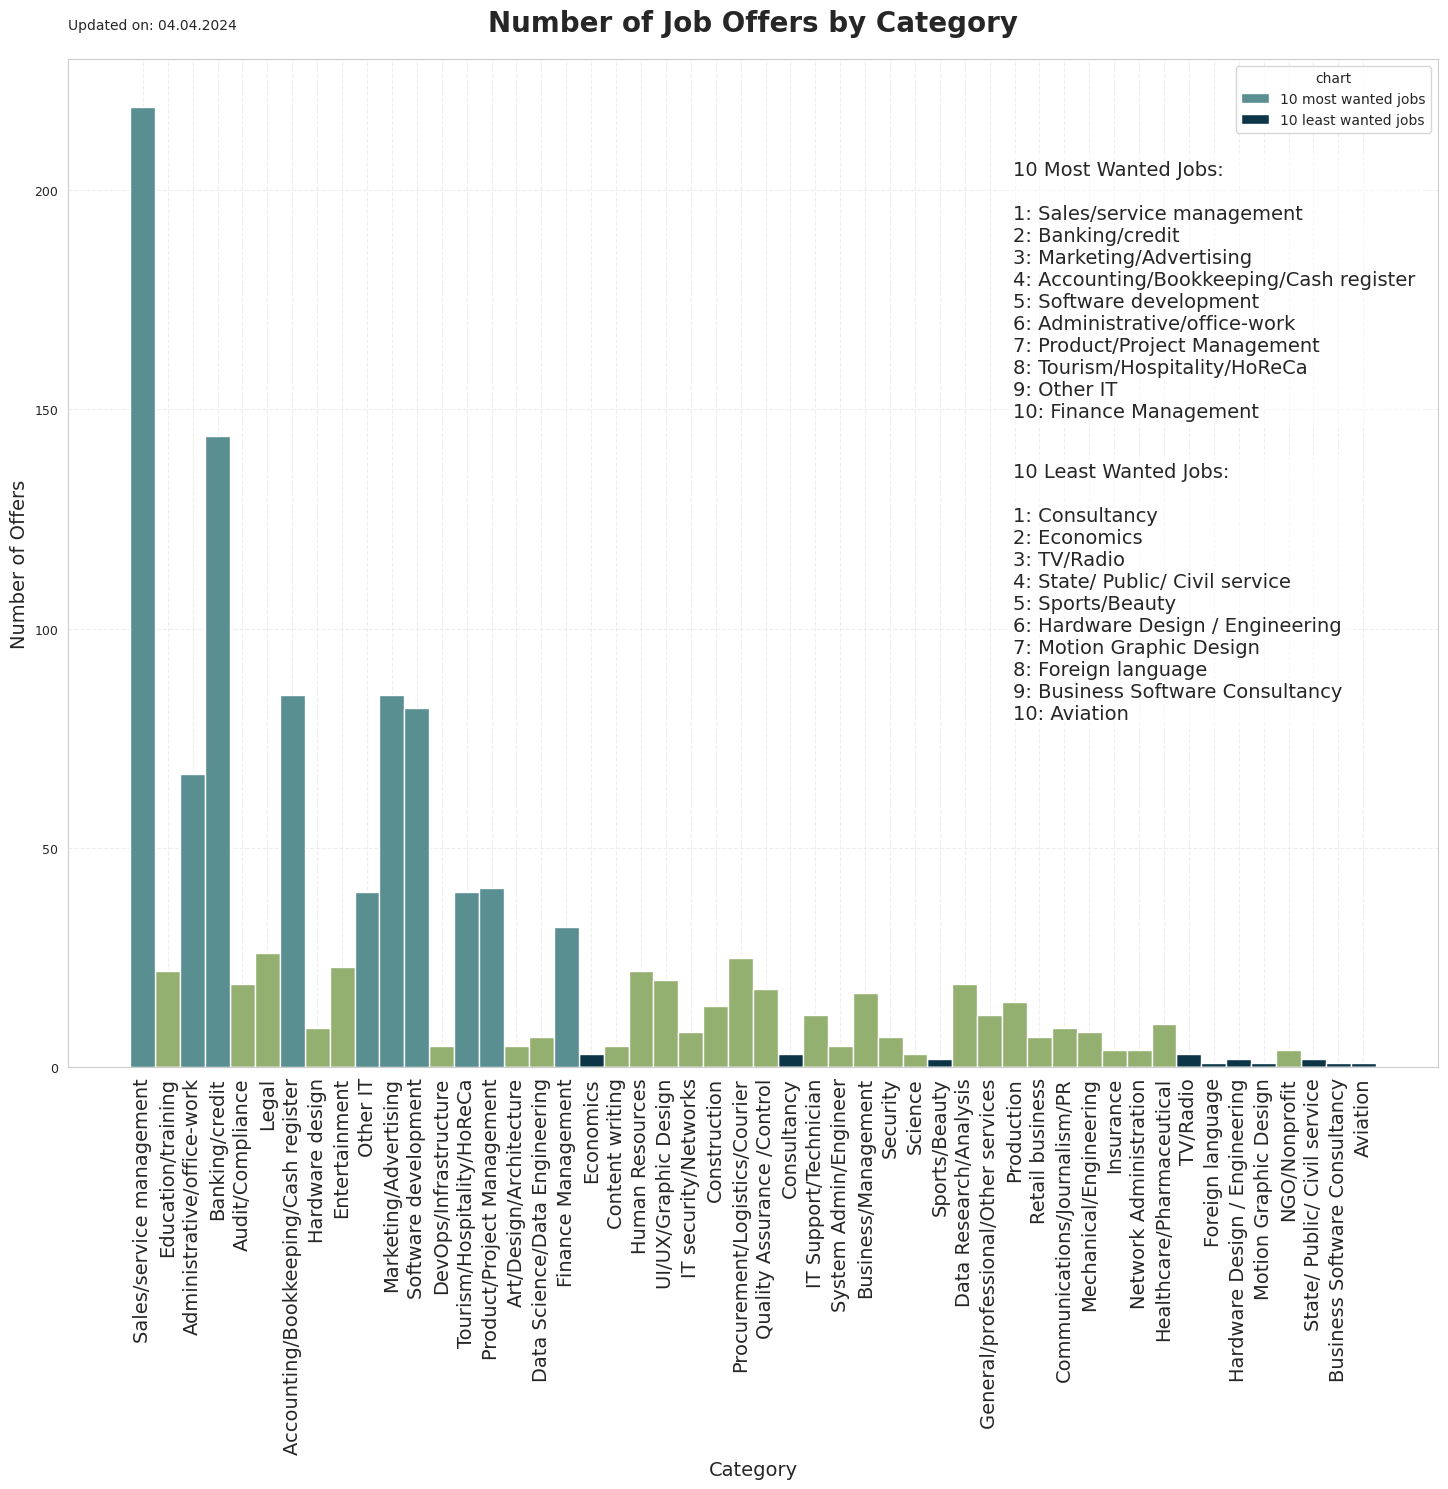

In [120]:
#preparing data
top_categories = jobs_df['Category'].value_counts().head(10).copy()
least_needed = jobs_df['Category'].value_counts().tail(10).copy()
jobs_df['chart'] = '_'
jobs_df.loc[jobs_df['Category'].isin(top_categories.index), 'chart'] = '10 most wanted jobs'
jobs_df.loc[jobs_df['Category'].isin(least_needed.index), 'chart'] = '10 least wanted jobs'



#plotting
plt.figure(figsize=(15, 15))


#stylling plot
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.color': '#EEEEEE'})

#setting diagram
sns.histplot(data=jobs_df, x='Category', hue='chart', palette=COLORS[:3], alpha = 1,)

#customizing labels and title
plt.title('Number of Job Offers by Category', fontsize = 20, fontweight='bold', pad=20)
plt.xlabel('Category', fontsize = 14)
plt.ylabel('Number of Offers', fontsize=14)
plt.xticks(rotation=90, fontsize=14) #ha='right', 
plt.yticks(fontsize=9)


#adding custom texts
top_10_text = '\n'.join([f"{i+1}: {cat}" for i, cat in enumerate(top_categories.index)])
plt.text(0.69, 0.90, f"10 Most Wanted Jobs:\n\n{top_10_text}", 
         fontsize=14, va='top', ha='left', 
         transform=plt.gca().transAxes, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

least_10_text = '\n'.join([f"{i+1}: {cat}" for i, cat in enumerate(least_needed.index)])
plt.text(0.69, 0.60, f"10 Least Wanted Jobs:\n\n{least_10_text}", 
         fontsize=14, va='top', ha='left', 
         transform=plt.gca().transAxes, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


#adding update date
plt.text(0,1.03,DATE, transform = plt.gca().transAxes)

plt.tight_layout()

#saving diagram

save_figure(1)
#plt.savefig('diagram1.png')

jobs_df.drop(columns = ['chart'],inplace = True)

# Diagram 2
### Spread of Job Offers by Location

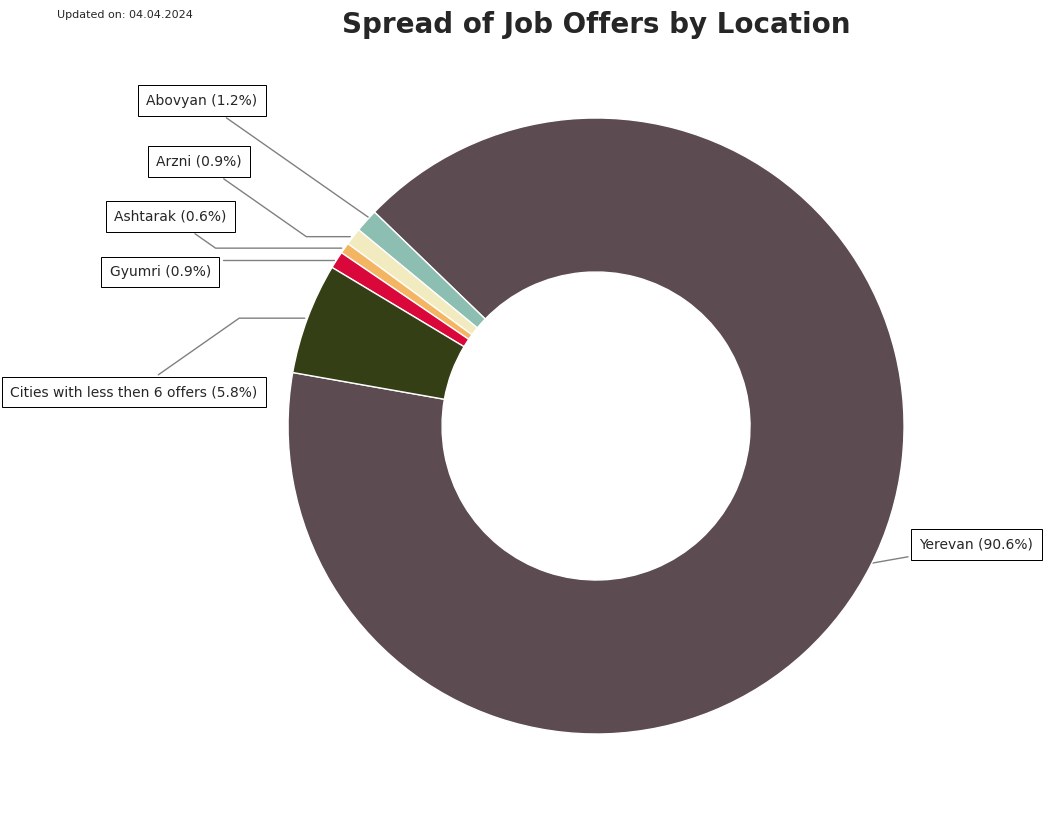

In [121]:
#preparing data
location_data = jobs_df['Location'].value_counts(sort = False)
min_count = 6
final_loc_data = location_data[location_data>=min_count]
small_data = location_data[location_data<min_count]
small_data_sum = small_data.sum()
final_loc_data[f'Cities with less then {min_count} offers'] =  small_data_sum

#plotting
fig, ax = plt.subplots(figsize = (15,10), subplot_kw = dict(aspect = 'equal'))

#setting diagram
wedges, texts= ax.pie(final_loc_data.values, colors = COLORS_12[:len(final_loc_data)],wedgeprops = dict(width = 0.5), startangle = 170)
bbox_props = dict(boxstyle = "square, pad=0.6", fc = 'w', ec = 'k', lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color = 'grey'),
          bbox=bbox_props, zorder=0, va="center")

#customizing labels and title
ax.set_title('Spread of Job Offers by Location', fontsize = 20, fontweight = 'bold')
for i, p in enumerate(wedges):
    ang = ((p.theta2 - p.theta1)/2. + p.theta1)
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    angle_A = -35
    if i>3:
        angle_A = -angle_A
    elif i==0:
        angle_A = 10
    connectionstyle =  f"angle,angleA={angle_A},angleB=0,rad=0"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    number = (1.05*np.sign(x)-i*0.05, 1.4*(y-i*0.09)+0.25)
    percent = 100 * final_loc_data.values[i] / final_loc_data.values.sum()
    if i>4:
        number = (1.1*np.sign(x), 1.4*(y-i*0.09)+0.25)
    ax.annotate(f'{final_loc_data.index[i]} ({percent:.1f}%)', xy=(x, y), xytext=number,
                horizontalalignment=horizontalalignment, **kw)


#adding update date
plt.text(-0.2,1.03,DATE, transform = plt.gca().transAxes, fontsize = 8)


#saving diagram
save_figure(2)

# Diagram 3
### Most Viewed jobs

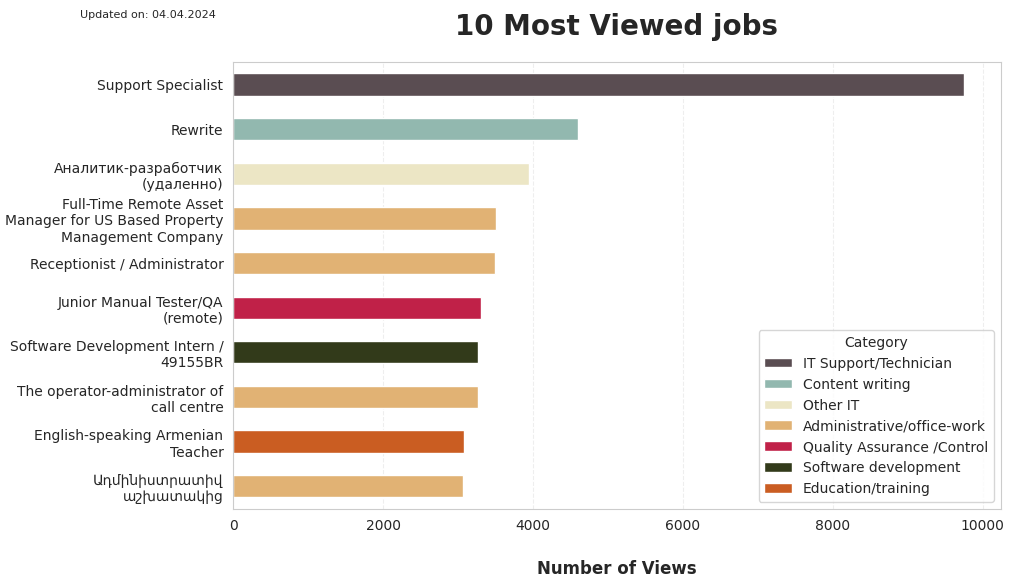

In [122]:
#preparing data
COUNT = 10
most_viewed = jobs_df.nlargest(COUNT, 'Number of Views').copy()

#stylling plot
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.color': '#EEEEEE'})

#plotting
plt.figure(figsize=(10, 6))

#customizing diagram
custom_hue = 'Category'
cmap = COLORS_12[:most_viewed[custom_hue].nunique()]

#setting diagram
sns.barplot(data = most_viewed, y='Job title', x = 'Number of Views',
            hue = custom_hue, palette =  cmap, errorbar = None,width=0.5)#alpha = 1)

#customizing labels and title
plt.xticks()
plt.yticks(wrap = True)

plt.title(f'{COUNT} Most Viewed jobs', fontsize = 20, fontweight='bold', pad=20)
plt.xlabel('Number of Views', fontsize = 12,fontweight='bold', labelpad = 20)

#adding update date
plt.text(-0.2,1.1,DATE, transform = plt.gca().transAxes, fontsize = 8)


plt.tight_layout()

#saving diagram
save_figure(3)

# Diagram 4
### Top 10 Companies by Job Offer Count

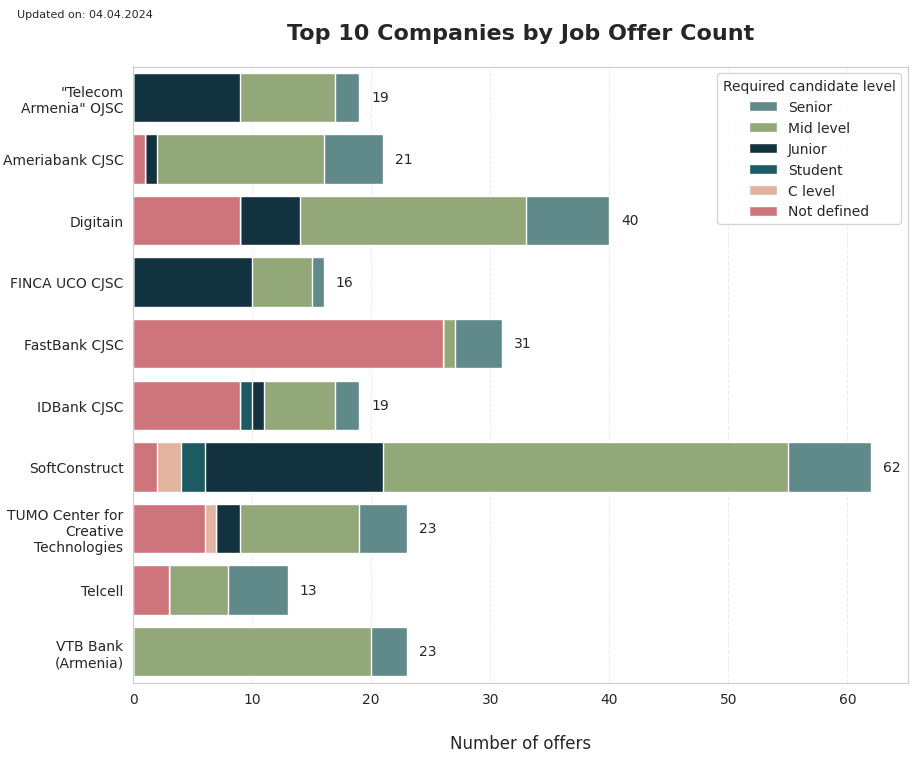

In [123]:
#preparing data
companies = jobs_df['Company name'].value_counts().head(10)
top_10_companies = companies.head(10)
mask = jobs_df['Company name'].isin(companies.index)
filtered_jobs = jobs_df[mask]

pivot_table = pd.pivot_table(filtered_jobs, index = 'Company name', 
                             columns = 'Required candidate level',
                            aggfunc = 'size',
                            fill_value = 0).reindex(columns = ['Senior','Mid level','Junior','Student','C level','Not defined'])

pivot_table = pd.concat([pivot_table, companies], axis=1)
pivot_table.rename(columns = {'count':'0'}, inplace = True)

level_list = ['Senior','Mid level','Junior','Student','C level','Not defined']

for i,level in enumerate(level_list[:-1],start = 1):
    pivot_table[str(i)] = pivot_table[str(i-1)] - pivot_table[level]

pivot_table['Company name'] = pivot_table.index

#plotting
fig, ax = plt.subplots(figsize=(10, 8))

#stylling diagram

cmp = COLORS[:len(companies)]

#setting diagram
for i,level in enumerate(level_list):
    sns.barplot(data = pivot_table, y = 'Company name', x = str(i), color = cmp[i], label = level)
    if i==0:
        for _, p in enumerate(ax.patches):
            total_offers = int(p.get_width())
            ax.text(total_offers + 1, p.get_y() + p.get_height() / 2, f'{total_offers}', ha='left', va='center')

#customizing labels and title
plt.legend(title = 'Required candidate level')
plt.title('Top 10 Companies by Job Offer Count', fontweight = 'bold', fontsize =16, pad = 20)
plt.ylabel('')
plt.xlabel('Number of offers', labelpad = 20, fontsize = 12)
plt.yticks(wrap = True)


#adding update date
plt.text(-0.15,1.08,DATE, transform = plt.gca().transAxes, fontsize = 8)



#saving diagram
save_figure(4)

# Diagrams 5 & 6
### Most In-Demand Skills

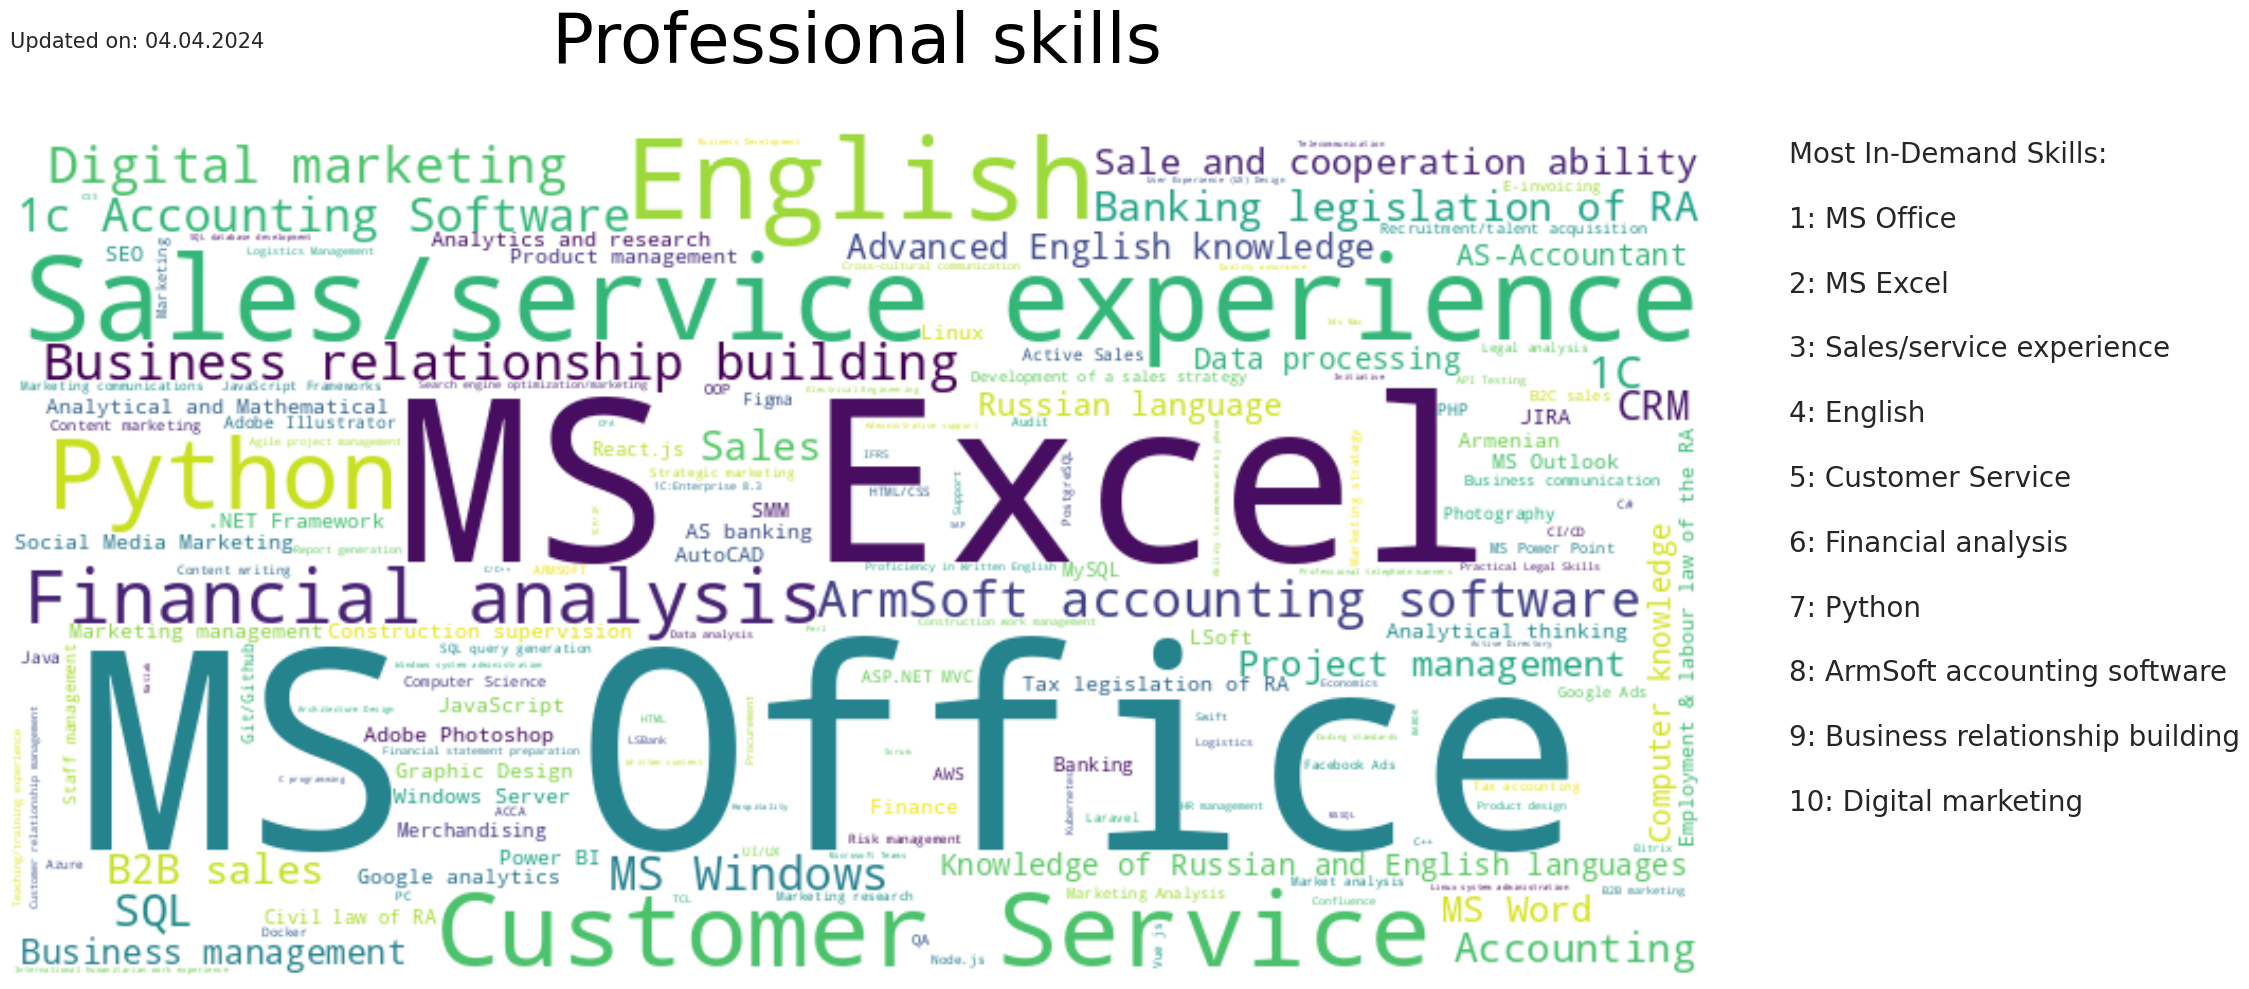

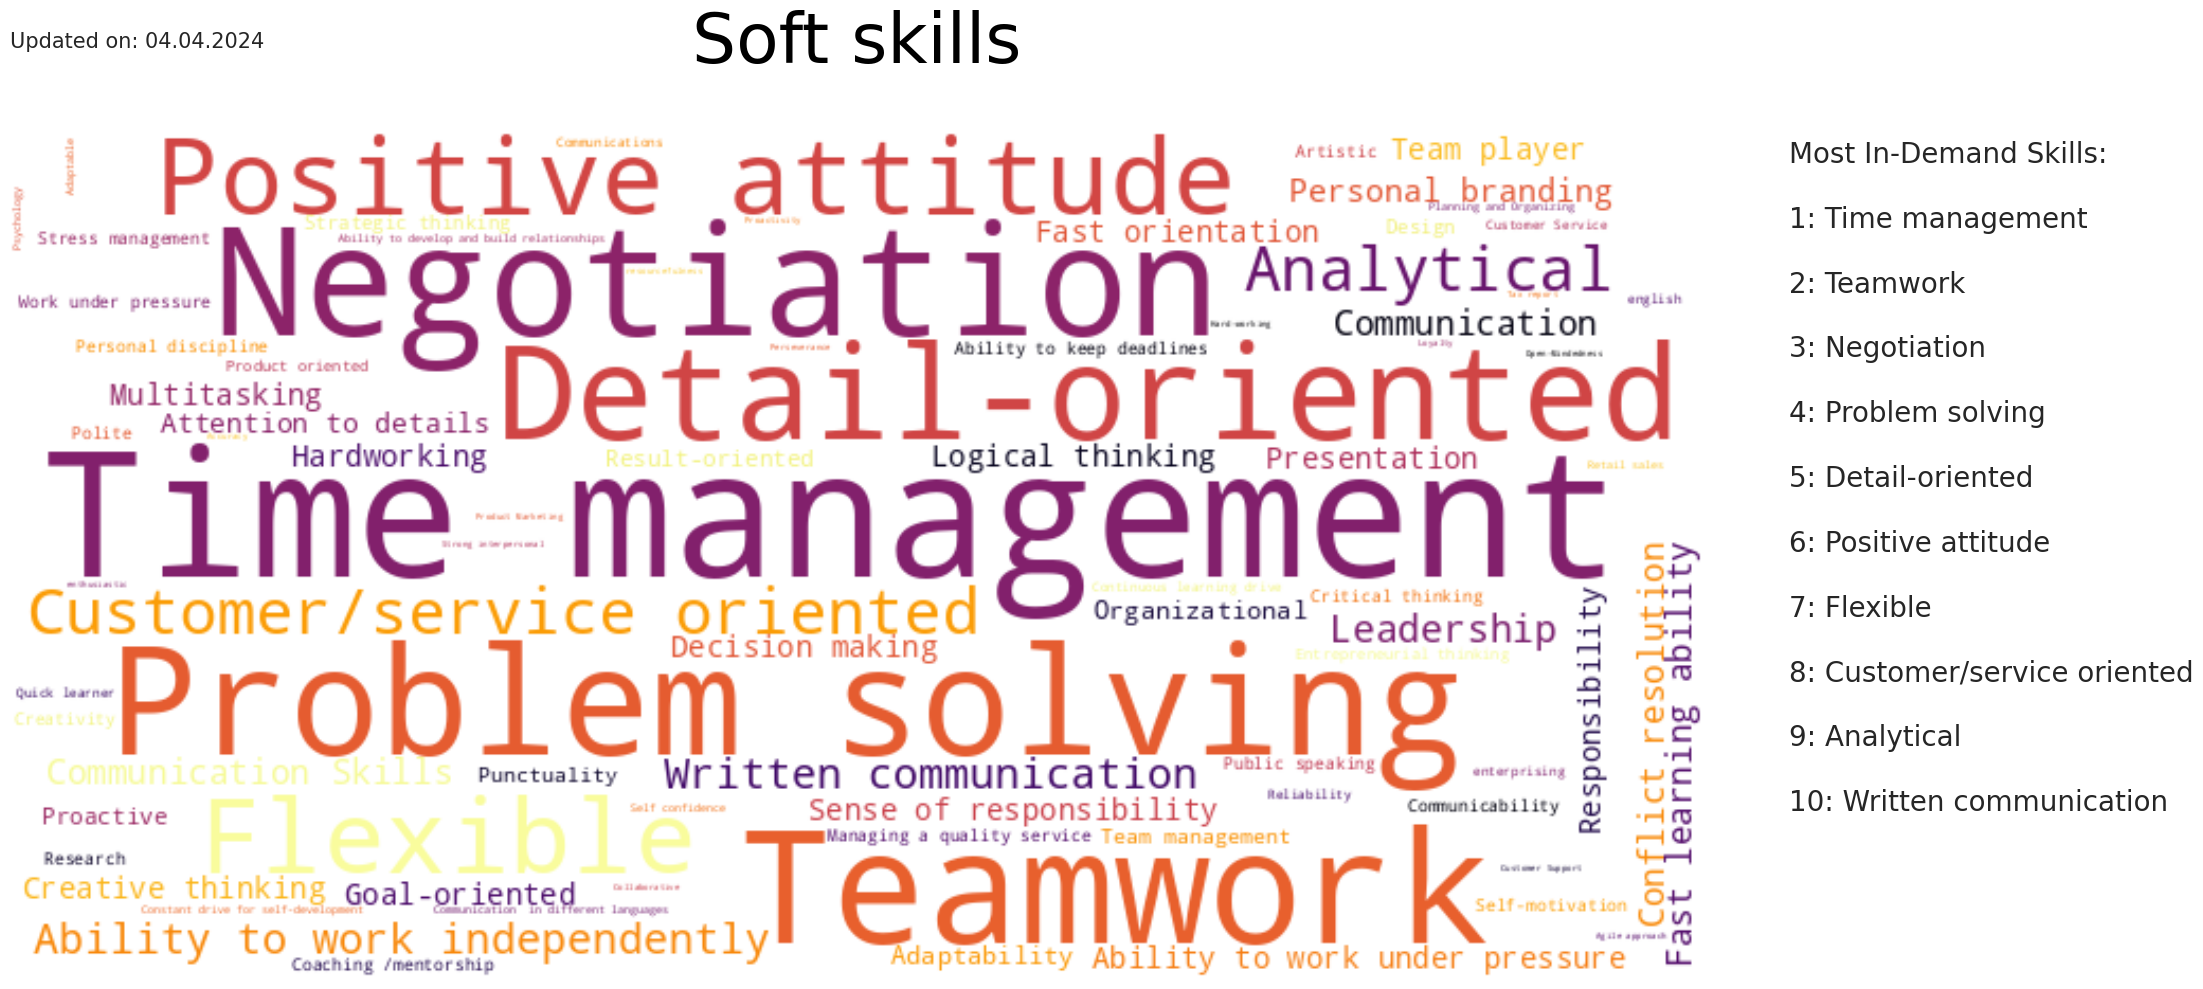

In [124]:
from collections import defaultdict
colormaps = ['viridis', 'inferno']
titles=['Most In-Demand', 'Least In-Demand']

for number,skill in enumerate(['Professional skills', 'Soft skills']):
    #preparing data
    count_dict = defaultdict(int)
    for l in  jobs_df[skill]:
        for s in eval(l):
            if ',' in s and 'Postman' not in s:
                new_l = [x.strip() for x in s.split(',')]
                for a in new_l:
                    a=a.replace('skills','')
                    count_dict[a]+=1
                continue
            s=s.replace('skills','')
            count_dict[s]+=1
    count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1]))

    #plotting
    plt.figure(figsize=(30, 11))
    
    #setting diagram
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap=colormaps[number]).generate_from_frequencies(count_dict)

    #customizing labels and title
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{skill}', fontsize = 50,  color = 'black', pad = 50, )

    #adding custom texts
    least_10_text = '\n\n'.join([f"{i+1}: {cat}" for i, cat in enumerate(list(count_dict.keys())[-1:-11:-1])])
    plt.text(1.05, 0.99, f"Most In-Demand Skills:\n\n{least_10_text}", 
         fontsize=20, va='top', ha='left', 
         transform=plt.gca().transAxes)
    
    #adding update date
    plt.text(0,1.1,DATE, transform = plt.gca().transAxes, fontsize = 15)
    
    plt.tight_layout
    
    #saving diagram
    save_figure(number+5)

# Diagram 7
### Top 10 Jobs with Highest Salary

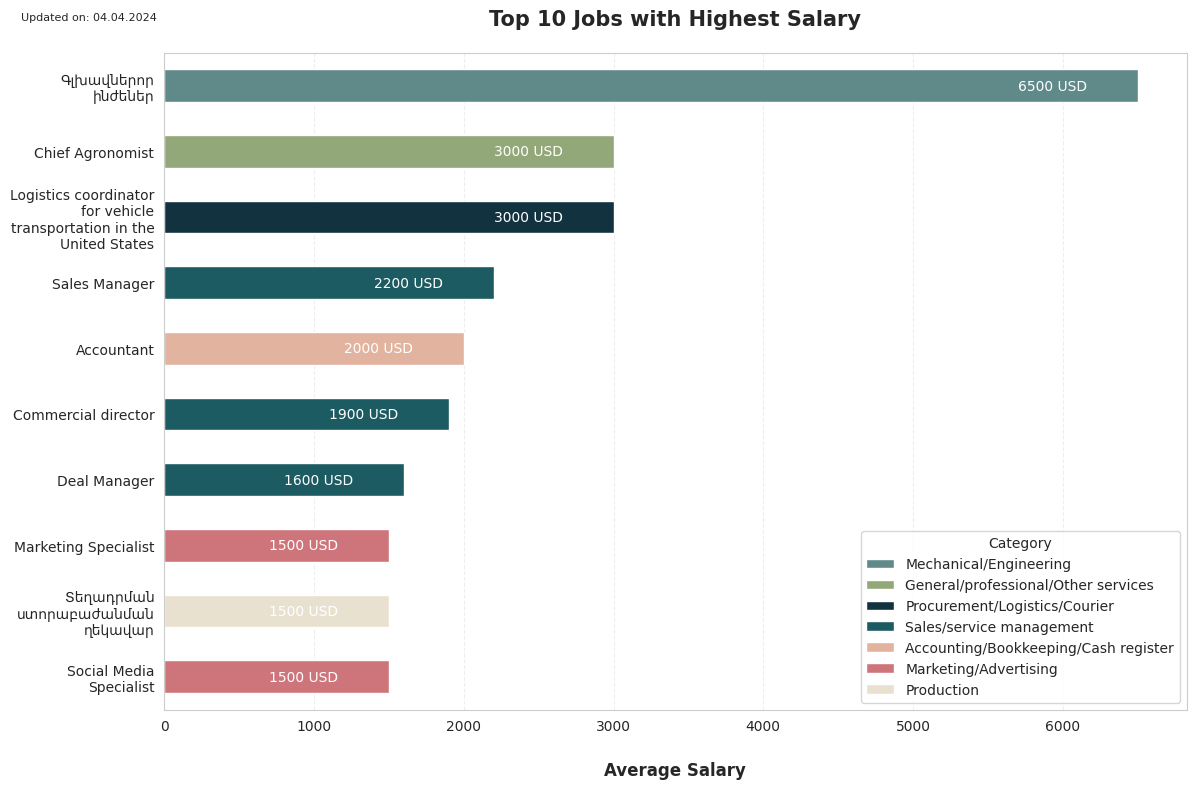

In [125]:
#preparing data
jobs_with_salary = jobs_df[jobs_df['Av_salary'].notna()].copy()
jobs_with_salary = jobs_with_salary.sort_values(by='Av_salary', ascending = False)


#stylling diagram
custom_hue = 'Category'
cmap = COLORS[:jobs_with_salary[custom_hue].nunique()]


#plotting
fig, ax =  plt.subplots(figsize=(12, 8))
#stylling plot
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.color': '#EEEEEE'})
#setting diagram
sns.barplot(data = jobs_with_salary.head(10), y='Job title', x = 'Av_salary',
            hue = custom_hue, palette =  cmap,
            errorbar = None,width=0.5)#alpha = 1)

#customizing labels and title
plt.yticks(wrap = True)
plt.title('Top 10 Jobs with Highest Salary', fontsize = 15, fontweight='bold', pad=20)
plt.ylabel('')
plt.xlabel('Average Salary', fontsize = 12,fontweight='bold', labelpad = 20)

#adding custom texts
for _, p in enumerate(ax.patches[:10]):
    total_offers = int(p.get_width())
    ax.text(total_offers -800, p.get_y() + p.get_height() / 2, f'{total_offers} USD', ha='left', va='center', color = 'white')


#adding update date
plt.text(-0.14,1.05,DATE, transform = plt.gca().transAxes, fontsize = 8)


plt.tight_layout()

#saving diagram
save_figure(7)

# Diagram 8
### Job Offers for Each Candidate Level

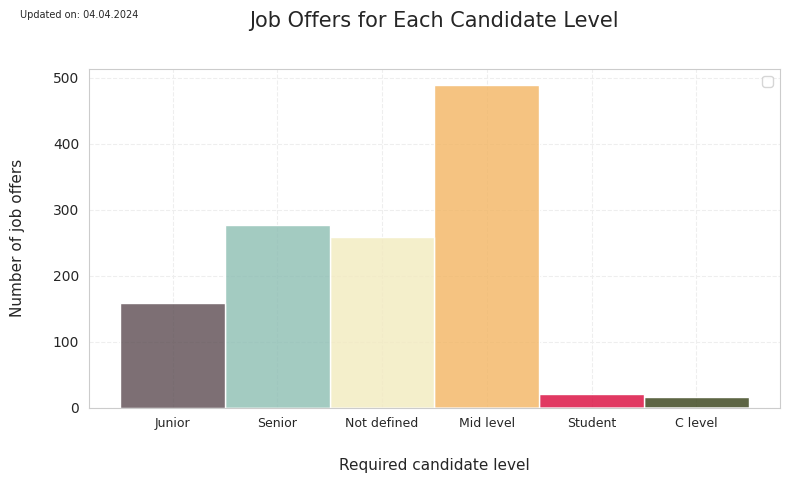

In [126]:
#plotting
plt.figure(figsize = (8,5))
#setting diagram
sns.histplot(data = jobs_df, x = 'Required candidate level', hue = 'Required candidate level', 
             palette= COLORS_12[:jobs_df['Required candidate level'].nunique()], alpha = 0.8)
#customizing labels and title
plt.legend('')
plt.title('Job Offers for Each Candidate Level', fontsize = 15, pad = 30)
plt.xticks(fontsize = 9,wrap = True)
plt.xlabel('Required candidate level',fontsize = 11,labelpad = 20)
plt.ylabel('Number of job offers',fontsize = 11, labelpad = 20)

#adding update date
plt.text(-0.1,1.15,DATE, transform = plt.gca().transAxes, fontsize = 7)

plt.tight_layout()

#saving diagram
save_figure(8)


# Diagram 9
### Impact of Date and Day of the Week on Deadline Selection

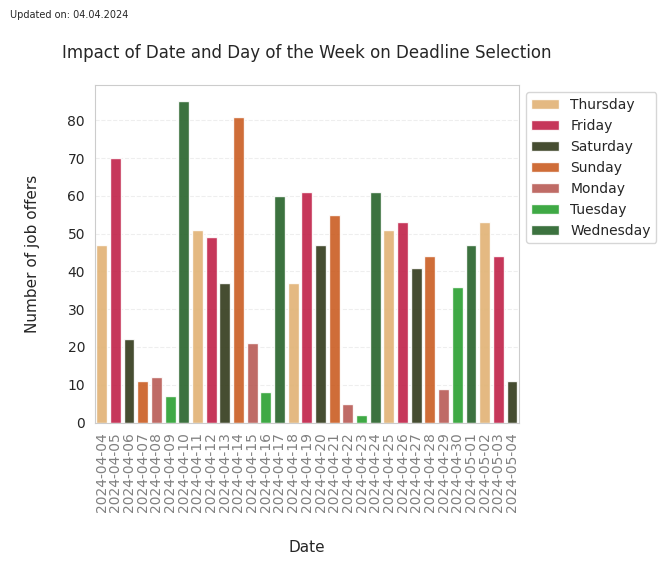

In [127]:
#preparing data
values = jobs_df['Deadline'].value_counts()
df = pd.DataFrame(values)
df['date'] = df.index
df['day of week'] = df['date'].dt.day_name()
df = df.sort_values(by = 'date')
#plotting
plt.figure(figsize = (7,6))
#setting diagram
sns.barplot(df, x = 'date', y = 'count', hue = 'day of week', palette = COLORS_12[3:10], alpha = 0.9)

#customizing labels and title
plt.title('Impact of Date and Day of the Week on Deadline Selection', pad = 20)
plt.xticks(rotation = 90, color = 'grey')
plt.xlabel('Date',fontsize = 11,labelpad = 20)
plt.ylabel('Number of job offers',fontsize = 11, labelpad = 20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

#adding update date
plt.text(-0.2,1.2,DATE, transform = plt.gca().transAxes, fontsize = 7)

plt.tight_layout()
#saving diagram
save_figure(9)


# Diagram 10
### correlation between the number of offers and salary

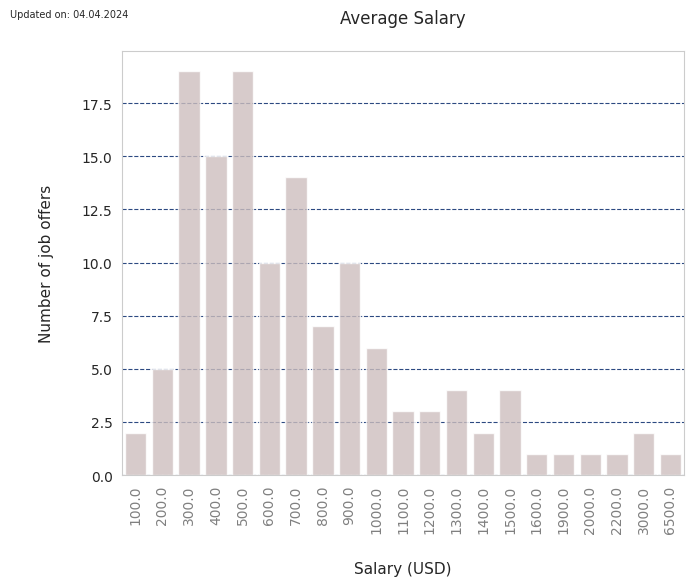

In [128]:
#preparing data
values = jobs_df['Av_salary'].value_counts()
df = pd.DataFrame(values)
df['salary'] = df.index
df = df.sort_values(by = 'salary')
#plotting
plt.figure(figsize = (7,6))
#stylling plot
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.color': COLORS_12[11]})
#setting diagram
sns.barplot(df, x = 'salary', y = 'count', alpha = 0.8,color = COLORS_L[7])
#customizing labels and title
plt.title('Average Salary', pad = 20,)
plt.xticks(rotation = 90, color = 'grey')
plt.xlabel('Salary (USD)',fontsize = 11,labelpad = 20)
plt.ylabel('Number of job offers',fontsize = 11, labelpad = 20)
#adding update date
plt.text(-0.2,1.08,DATE, transform = plt.gca().transAxes, fontsize = 7)

plt.tight_layout()
save_figure(10)